In [1]:
import torch
from tqdm import tqdm
import numpy as np
import scipy
import random
import glob
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import roc_auc_score, roc_curve
#from bindenergy import *
from bindenergy.models import DrugDataset, DrugAllAtomEnergyModel, load_esm_embedding
%env TORCH_EXTENSIONS_DIR=.
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

env: TORCH_EXTENSIONS_DIR=.


### Protein-Ligand Binding

Load model (DrugAllAtomEnergyModel considers the full-atom structure of a protein-ligand complex, including side-chains).

In [2]:
fn = "ckpts/model.drug.allatom"
model_ckpt, opt_ckpt, model_args = torch.load(fn)
model = DrugAllAtomEnergyModel(model_args).cuda()
model.load_state_dict(model_ckpt)
model.eval()

DrugAllAtomEnergyModel(
  (mse_loss): MSELoss()
  (mpn): MPNEncoder(
    (dropout_layer): Dropout(p=0.1, inplace=False)
    (act_func): ReLU()
    (W_i): Linear(in_features=147, out_features=256, bias=False)
    (W_h): Linear(in_features=256, out_features=256, bias=False)
    (W_o): Linear(in_features=389, out_features=256, bias=True)
  )
  (encoder): AllAtomEncoder(
    (W_bind): Linear(in_features=256, out_features=256, bias=True)
    (W_tgt): Linear(in_features=2560, out_features=256, bias=True)
    (A_bind): Embedding(38, 256)
    (A_tgt): Embedding(38, 256)
    (encoder): SRUpp(
      (rnn_lst): ModuleList(
        (0): SRUppCell(515, 128, dropout=0.1, bidirectional=True, highway_bias=-2.0,
          transform_module=SRUppAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (linear1): Linear(in_features=515, out_features=128, bias=False)
          (linear2): Linear(in_features=128, out_features=256, bias=False)
          (linear3): Linear(in_features=128, out_fe

In our NeurIPS paper, we used the PDBBind core (CASF 2016) as the test set. We use the docking test set from EquiBind (Starks et al., ICML 2022)as our validation set.

In our new biorxiv paper, we further evaluate DSMBind on Merck free energy perturbation (FEP) benchmark.

In [3]:
test_casf16 = DrugDataset("../../data/DSMBind/data/drug/test_casf16.pkl", 50)
test_equibind = DrugDataset("../../data/DSMBind/data/drug/test_equibind.pkl", 50)
test_fep = DrugDataset("../../data/DSMBind/data/drug/test_fep.pkl", 50)

  0%|          | 0/285 [00:00<?, ?it/s]

100%|██████████| 264/264 [00:00<00:00, 500.52it/s]


In [4]:
embedding = load_esm_embedding(test_equibind.data + test_casf16.data + test_fep.data, ['target_seq'])

100%|██████████| 498/498 [01:42<00:00,  4.86it/s]


Inference script (note: DSMBind predicted score is the higher the better, while binding affinity is the lower the better)

In [5]:
def pdbbind_evaluate(model, data, embedding, args):
    model.eval()
    score = []
    label = []
    with torch.no_grad():
        for entry in tqdm(data):
            binder, target = DrugDataset.make_bind_batch([entry], embedding, args)
            pred = model.predict(binder, target)
            score.append(-1.0 * pred.item())
            label.append(entry['affinity'])
    return scipy.stats.spearmanr(score, label)[0], score, label

Make predictions on CASF-2016/Equibind test sets 

In [6]:
casf16_corr, casf16_score, casf16_label = pdbbind_evaluate(
    model, test_casf16, embedding, model_args
)
equibind_corr, equibind_score, equibind_label = pdbbind_evaluate(
    model, test_equibind, embedding, model_args
)

100%|██████████| 363/363 [00:03<00:00, 102.09it/s]


Text(0.5, 1.0, 'CASF 2016 Spearman R = 0.6429')

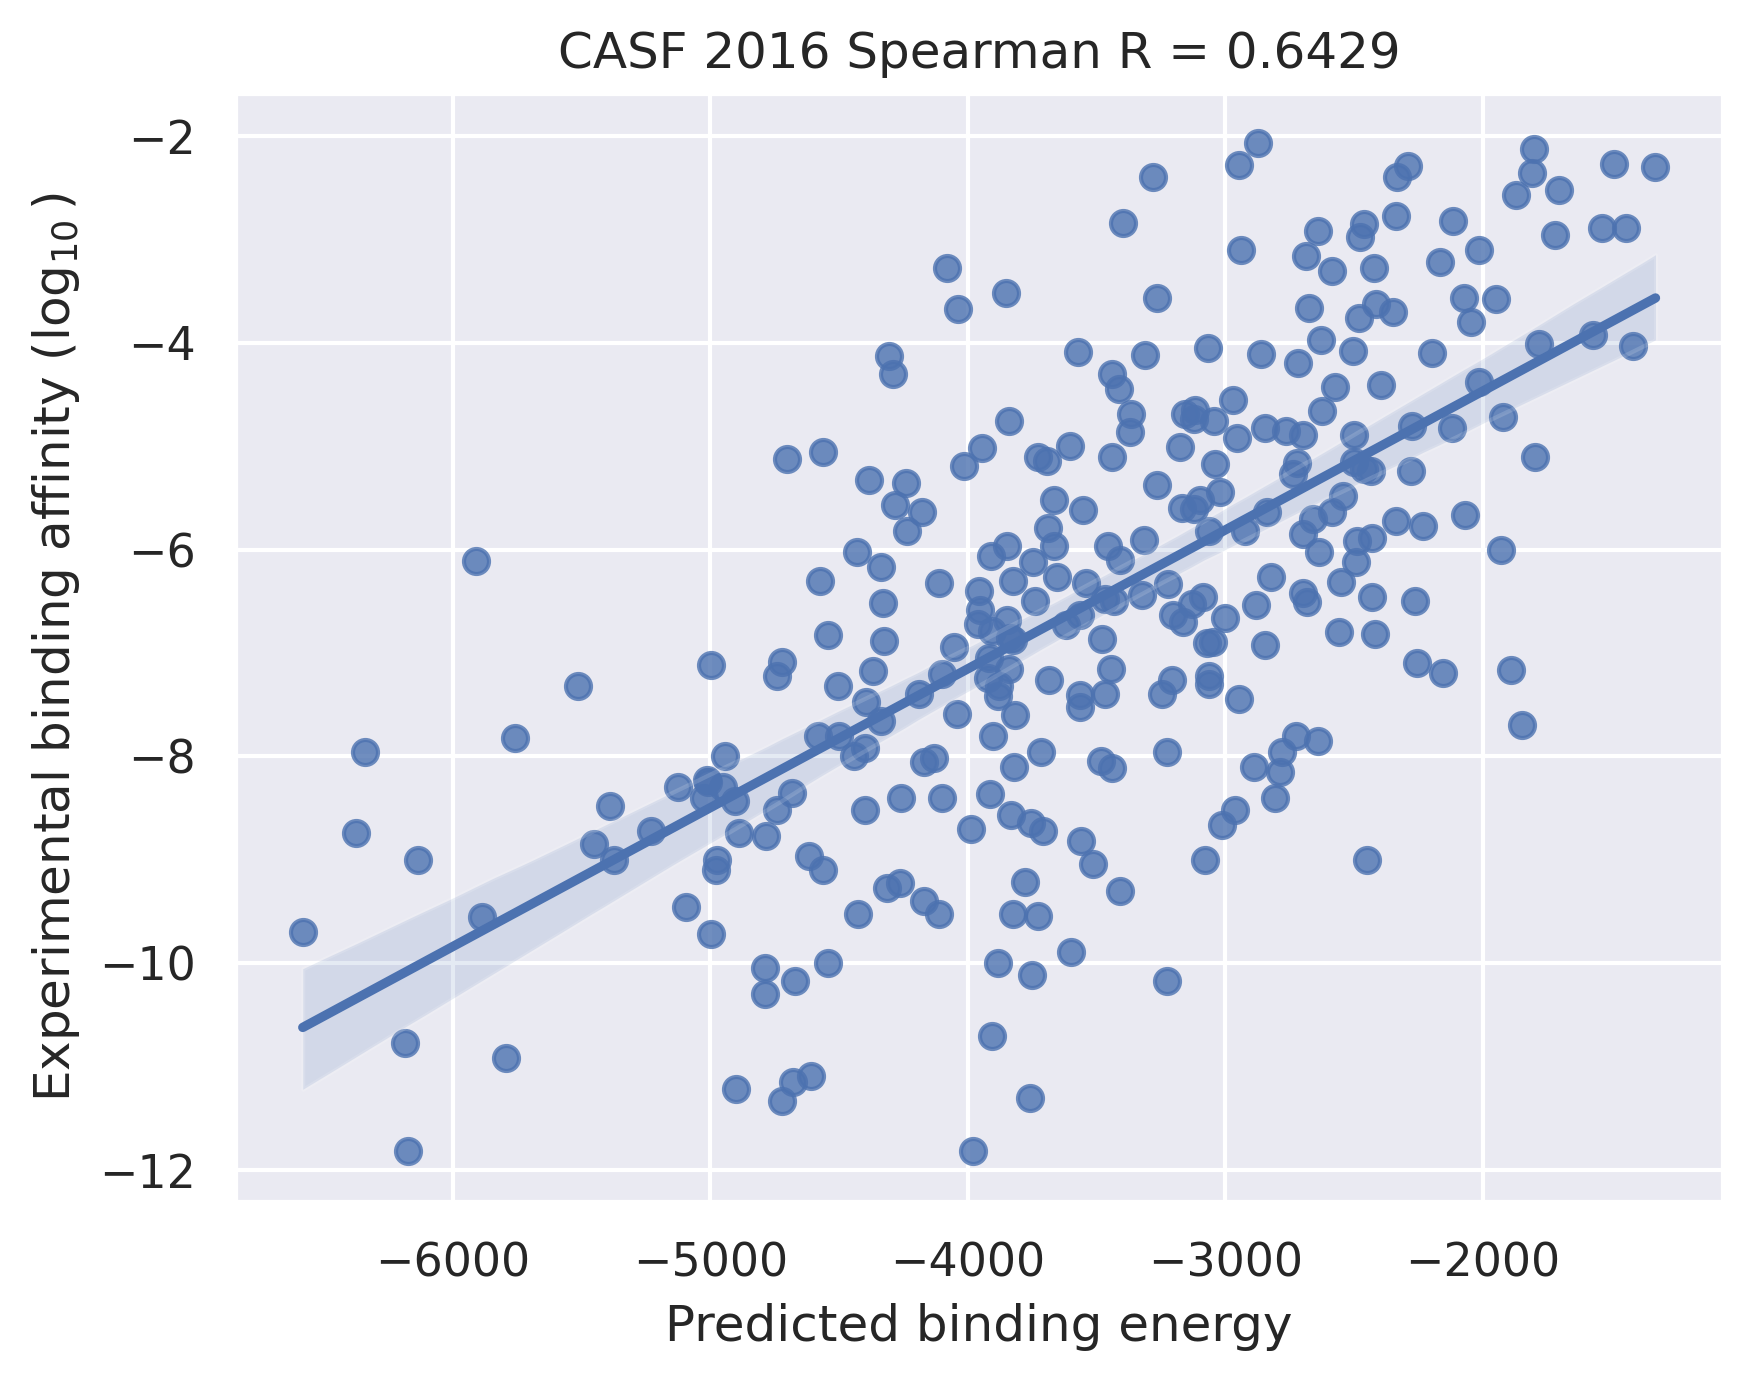

In [7]:
sns.regplot(x=casf16_score, y=casf16_label)
plt.xlabel('Predicted binding energy')
plt.ylabel('Experimental binding affinity ($\log_{10}$)')
plt.title(f'CASF 2016 Spearman R = {casf16_corr:.4f}')

Text(0.5, 1.0, 'Equibind test Spearman R = 0.5268')

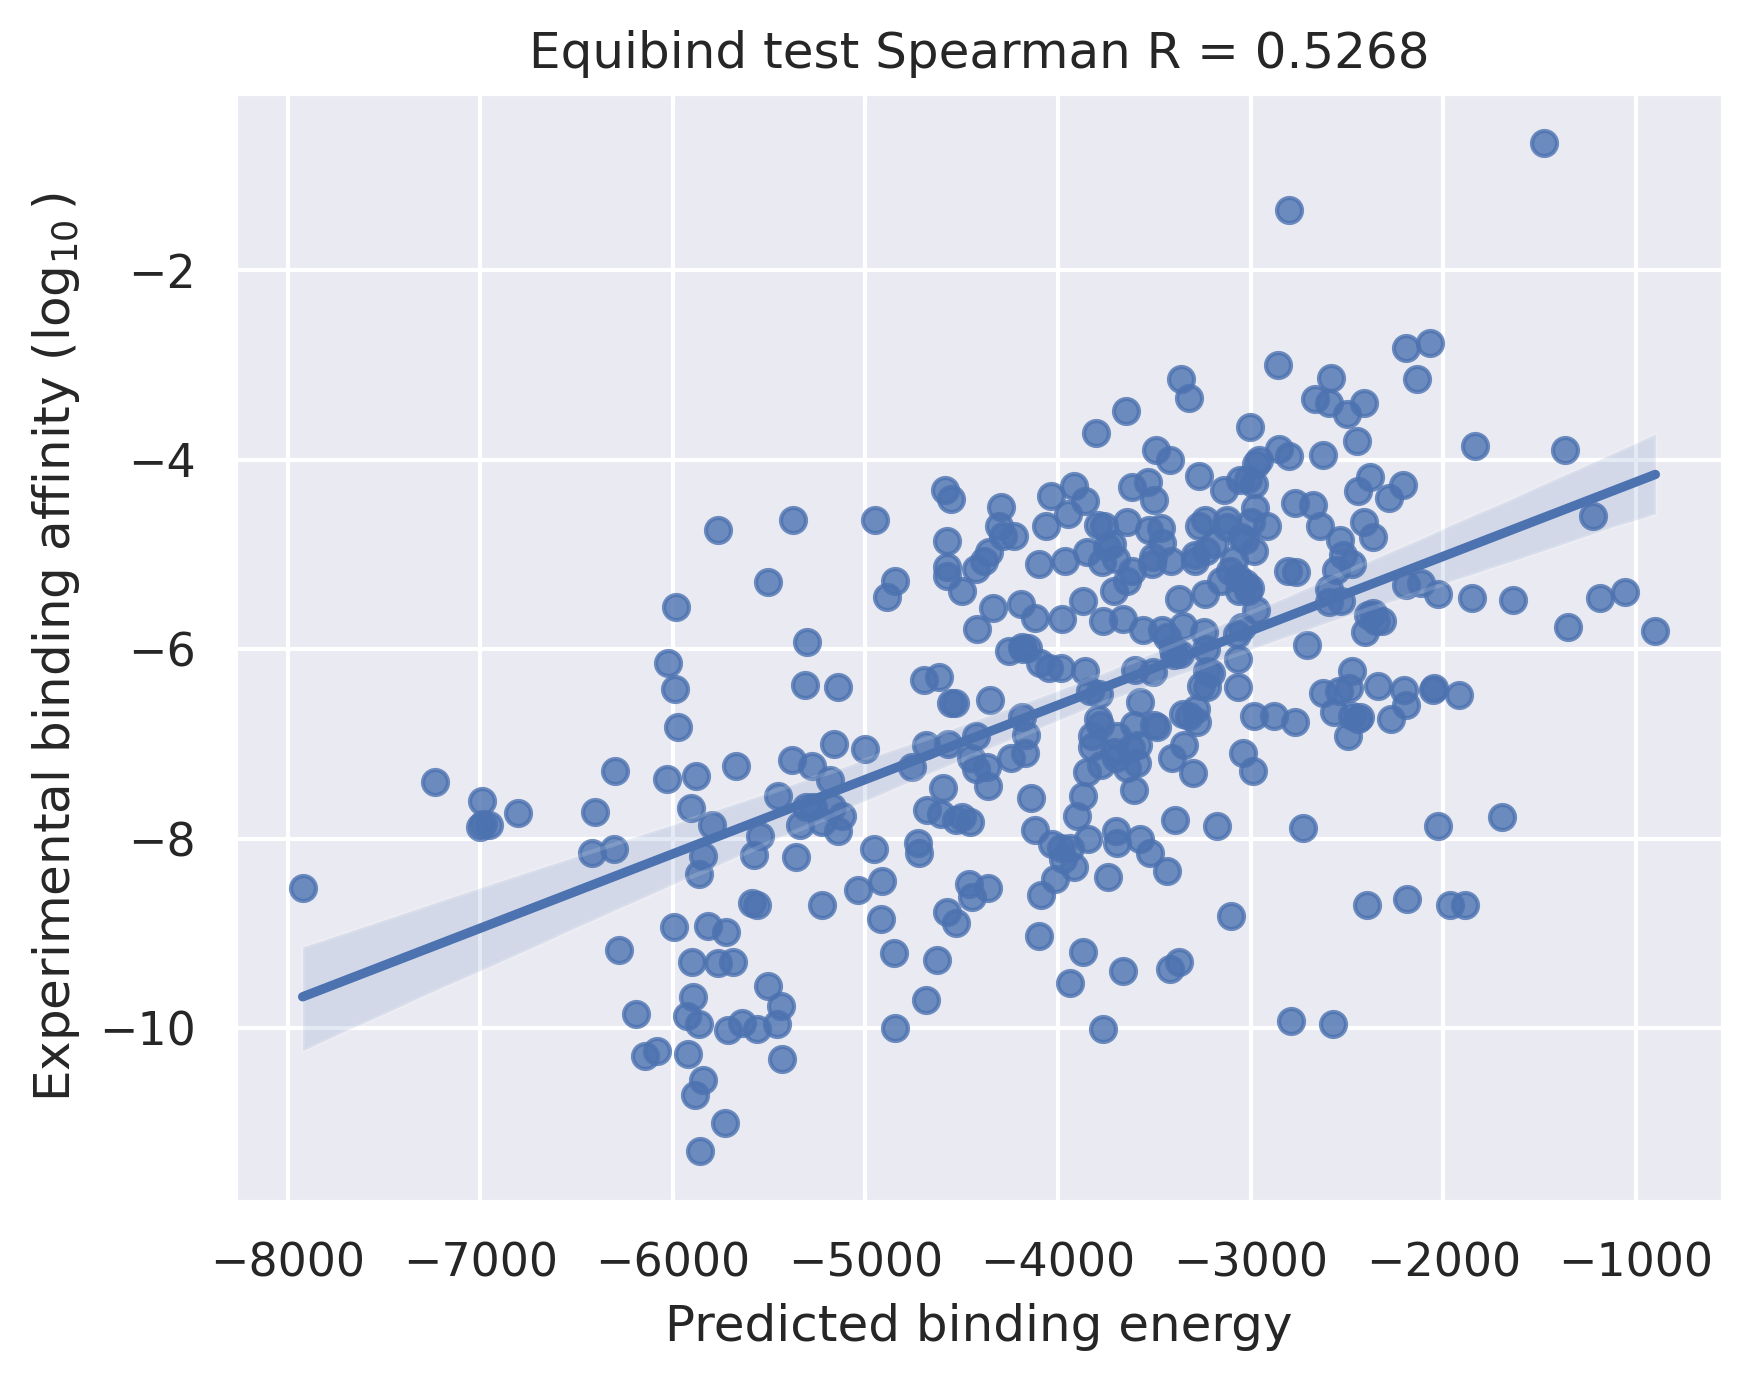

In [8]:
sns.regplot(x=equibind_score, y=equibind_label)
plt.xlabel('Predicted binding energy')
plt.ylabel('Experimental binding affinity ($\log_{10}$)')
plt.title(f'Equibind test Spearman R = {equibind_corr:.4f}')

##### Merck FEP Benchmark Evaluation

In [10]:
score = defaultdict(list)
label = defaultdict(list)
with torch.no_grad():
    for entry in tqdm(test_fep):
        pdb = entry['pdb']
        binder, target = DrugDataset.make_bind_batch([entry], embedding, model_args)
        pred = model.predict(binder, target)
        score[pdb].append(pred.item())
        label[pdb].append(-1.0 * entry['affinity'])

100%|██████████| 264/264 [00:02<00:00, 117.31it/s]


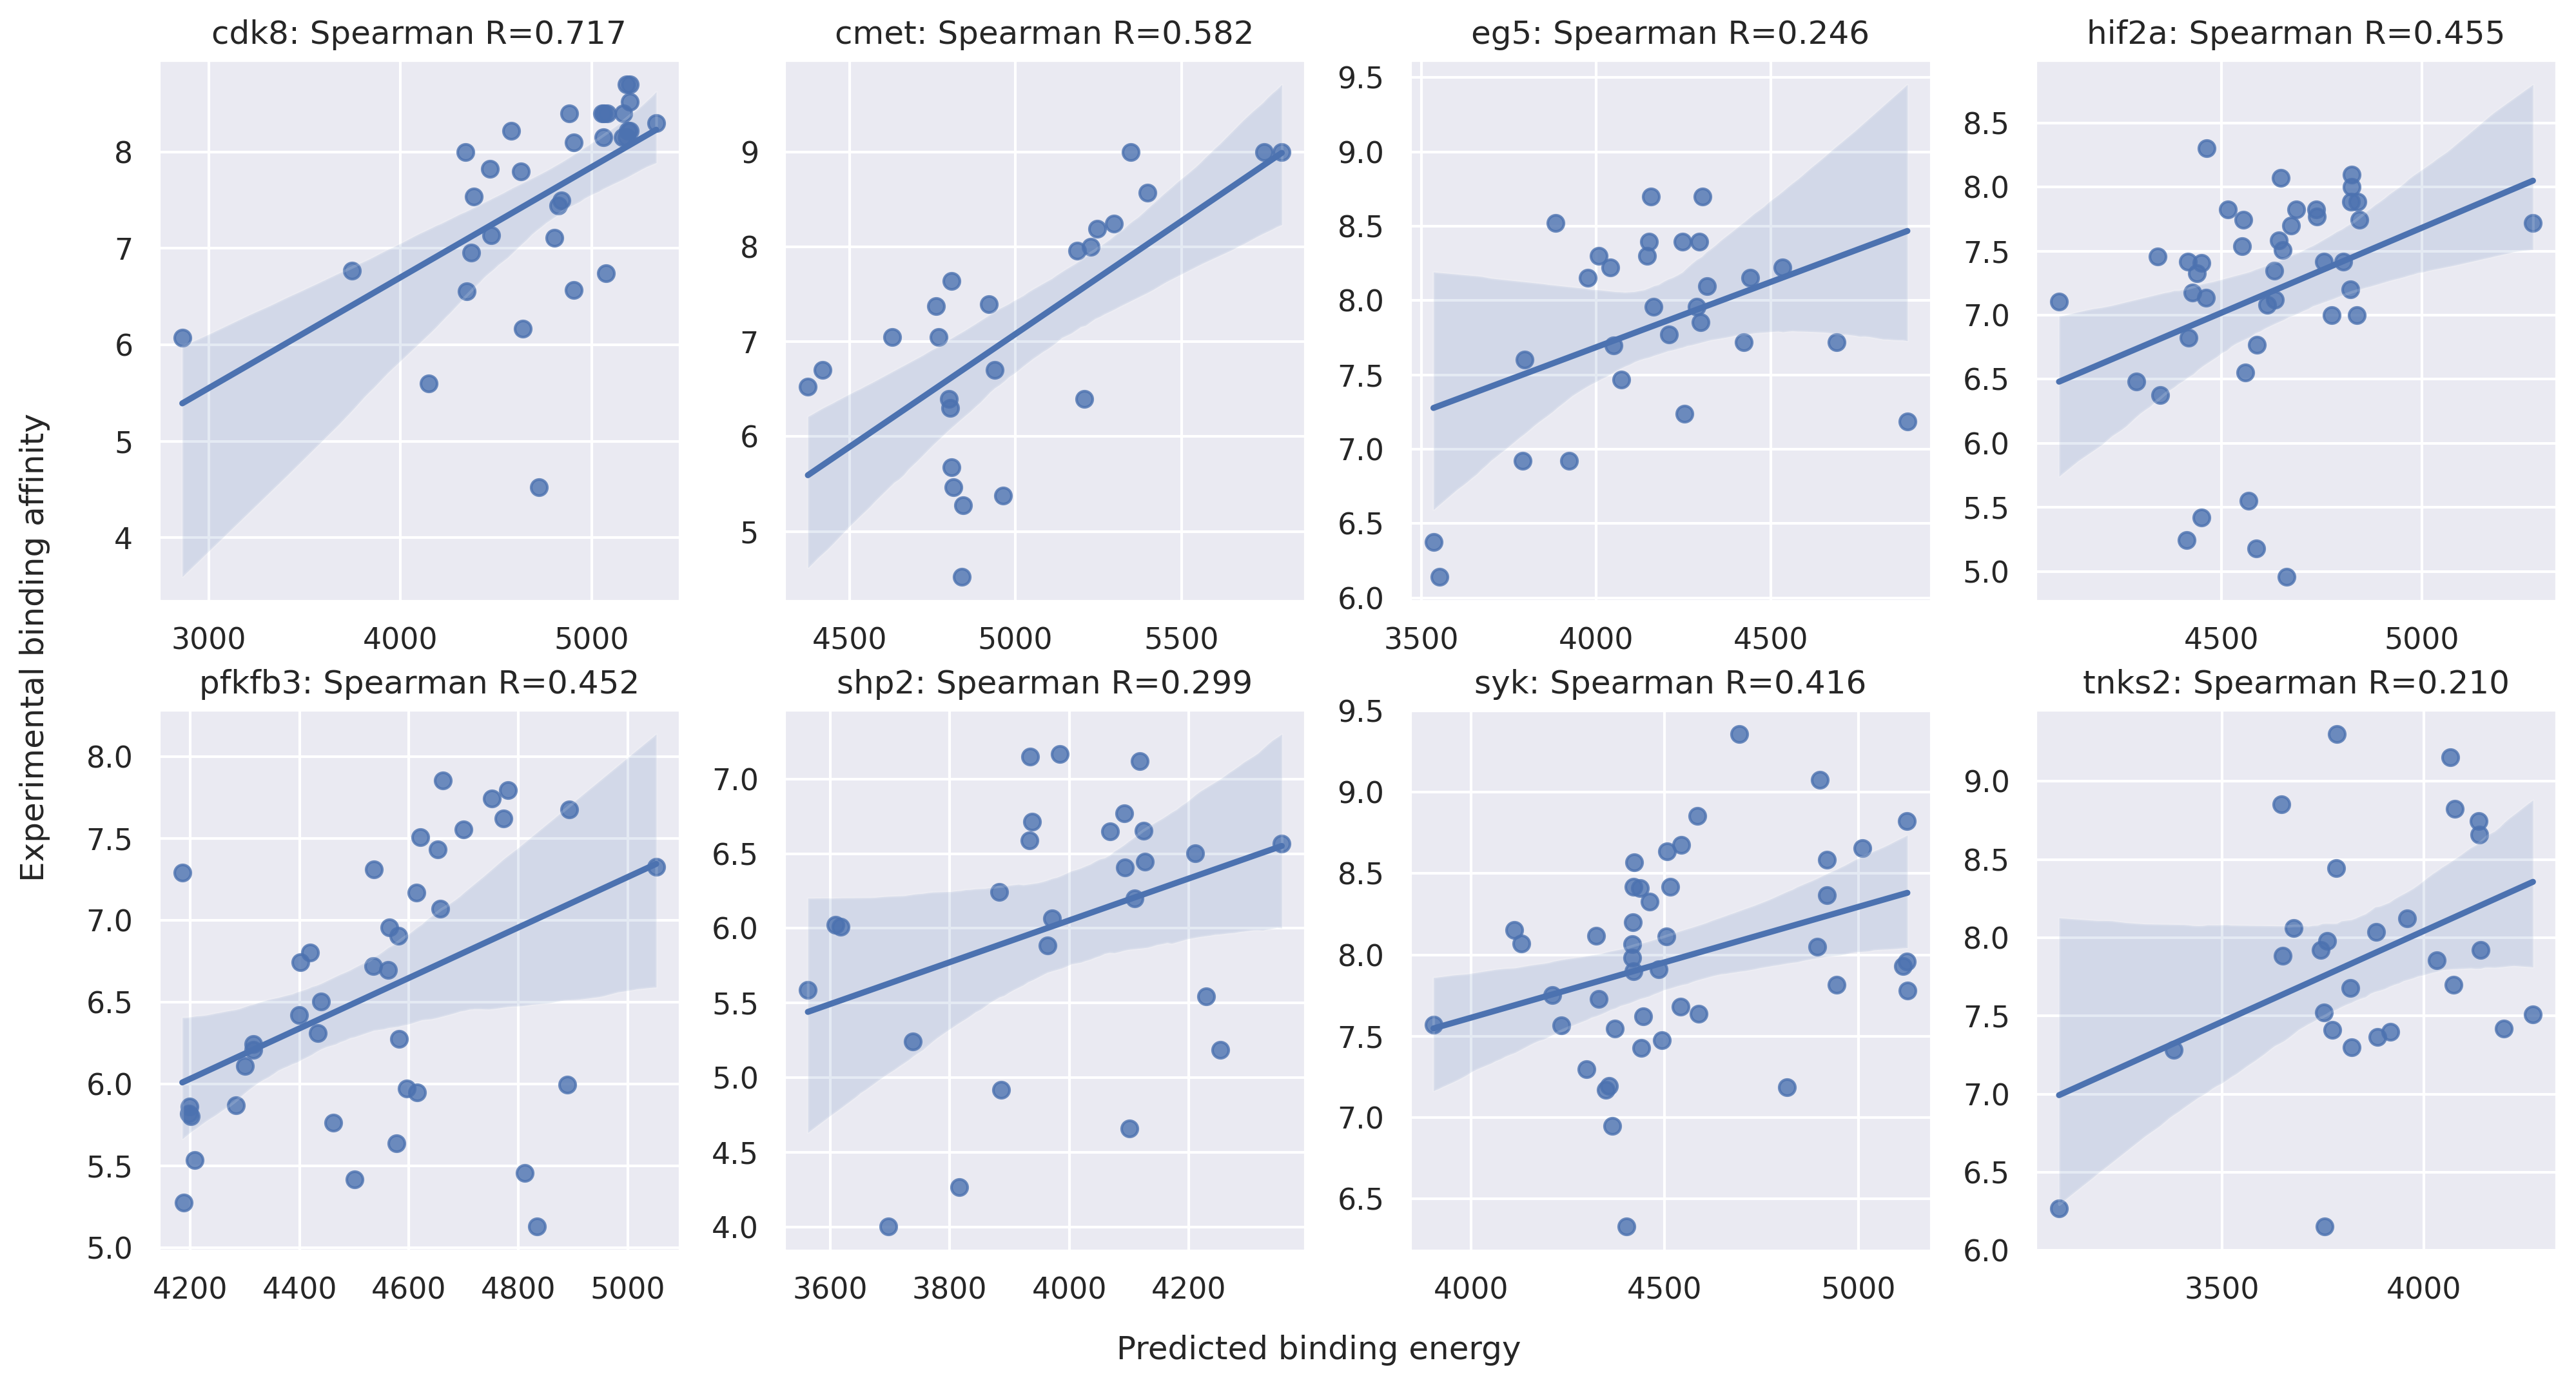

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
fig.text(0.5, 0.04, 'Predicted binding energy', ha='center')
fig.text(0.08, 0.5, 'Experimental binding affinity', va='center', rotation='vertical')
for i,pdb in enumerate(score.keys()):
    i, j = i // 4, i % 4
    sns.regplot(x=score[pdb], y=label[pdb], ax=axes[i,j])
    corr = scipy.stats.spearmanr(score[pdb], label[pdb])[0]
    axes[i,j].set_title(f'{pdb}: Spearman R={corr:.3f}')

### Antibody-Antigen Binding

In [12]:
def sabdab_evaluate(model, data, embedding, args):
    model.eval()
    pred, label = [], []
    for ab in tqdm(data):
        binder, target = AntibodyDataset.make_local_batch([ab], embedding, args)
        score = model.predict(binder, target)
        pred.append(-1.0 * score.item())
        label.append(ab['affinity'])
    return scipy.stats.spearmanr(pred, label)[0], pred, label

In our NeurIPS and biorxiv paper, we evaluate on two test sets:
* The first test set is from SAbDab. It has 566 antibody-antigen complexes with binding affinity labels
* The second test set is from . It has 424 HER2-trastuzumab variants (CDR3 mutation) with binding affinity labels

In [13]:
test_sabdab = AntibodyDataset("data/antibody/test_sabdab.jsonl", cdr_type='123456', epitope_size=50)
test_HER2 = AntibodyDataset("data/antibody/test_HER2.jsonl", cdr_type='123456', epitope_size=50)

100%|██████████| 422/422 [00:08<00:00, 50.60it/s]


In [14]:
embedding = load_esm_embedding(test_sabdab.data + test_HER2.data, ['antibody_seq', 'antigen_seq'])

100%|██████████| 513/513 [01:00<00:00,  8.51it/s]


In [15]:
model_ckpt, opt_ckpt, model_args = torch.load("ckpts/model.antibody.allatom")
model = AllAtomEnergyModel(model_args).cuda()
model.load_state_dict(model_ckpt)
model.eval()

AllAtomEnergyModel(
  (mse_loss): MSELoss()
  (encoder): AllAtomEncoder(
    (W_bind): Linear(in_features=2560, out_features=256, bias=True)
    (W_tgt): Linear(in_features=2560, out_features=256, bias=True)
    (A_bind): Embedding(63, 256)
    (A_tgt): Embedding(63, 256)
    (encoder): SRUpp(
      (rnn_lst): ModuleList(
        (0): SRUppCell(515, 128, dropout=0.1, bidirectional=True, highway_bias=-2.0,
          transform_module=SRUppAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (linear1): Linear(in_features=515, out_features=128, bias=False)
          (linear2): Linear(in_features=128, out_features=256, bias=False)
          (linear3): Linear(in_features=128, out_features=1024, bias=False)
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        )
        (1): SRUppCell(256, 128, dropout=0.1, bidirectional=True, highway_bias=-2.0,
          transform_module=SRUppAttention(
          (dropout): Dropout(p=0.1, inplace=F

In [16]:
test_corr, pred, label = sabdab_evaluate(model, test_sabdab, embedding, model_args)

100%|██████████| 566/566 [00:06<00:00, 91.59it/s]


Text(0.5, 1.0, 'SAbDab test correlation: Spearman R = 0.3605')

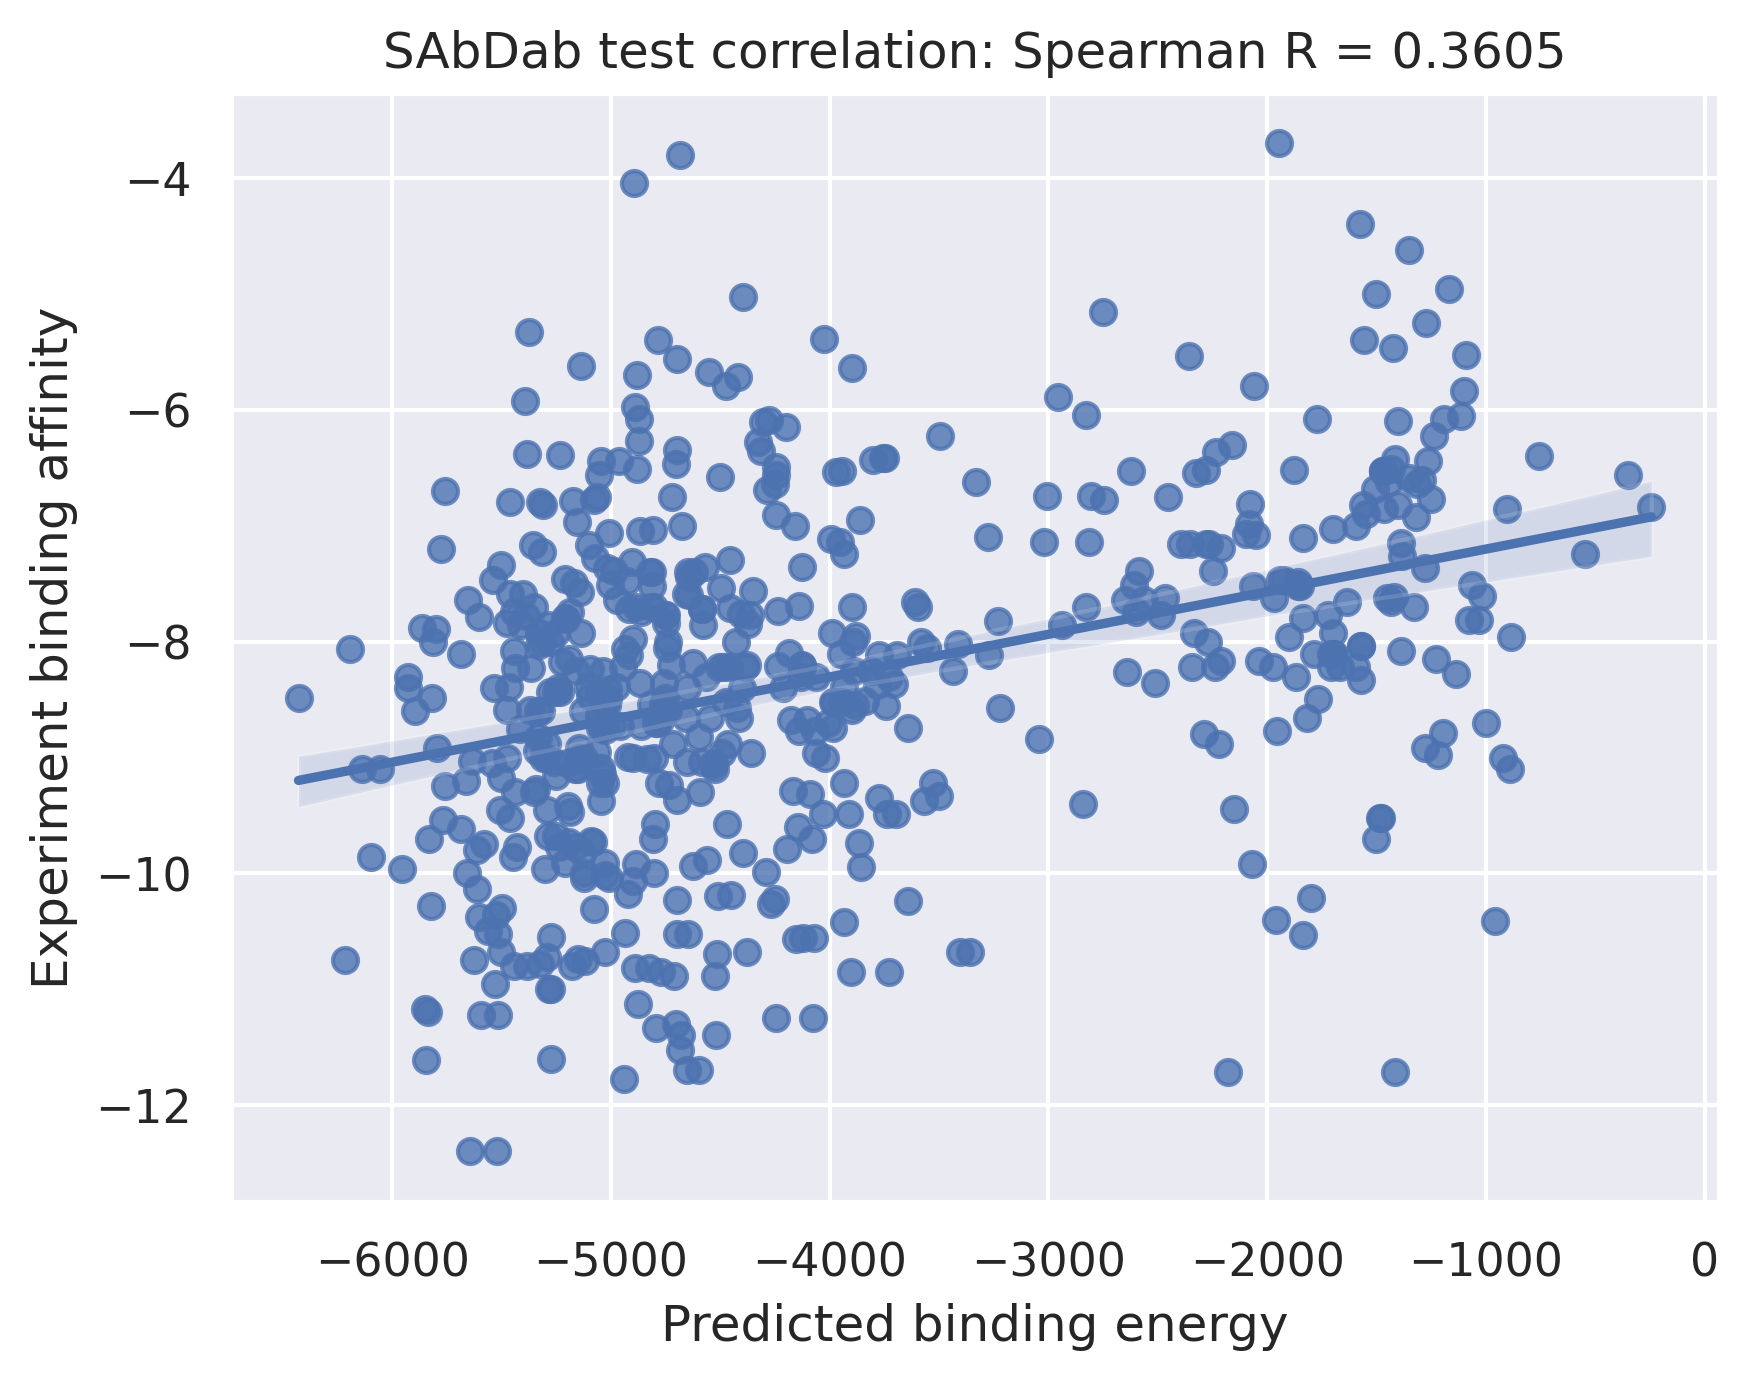

In [17]:
sns.regplot(x=pred, y=label)
plt.xlabel('Predicted binding energy')
plt.ylabel('Experiment binding affinity')
plt.title(f'SAbDab test correlation: Spearman R = {test_corr:.4f}')

100%|██████████| 422/422 [00:03<00:00, 105.75it/s]


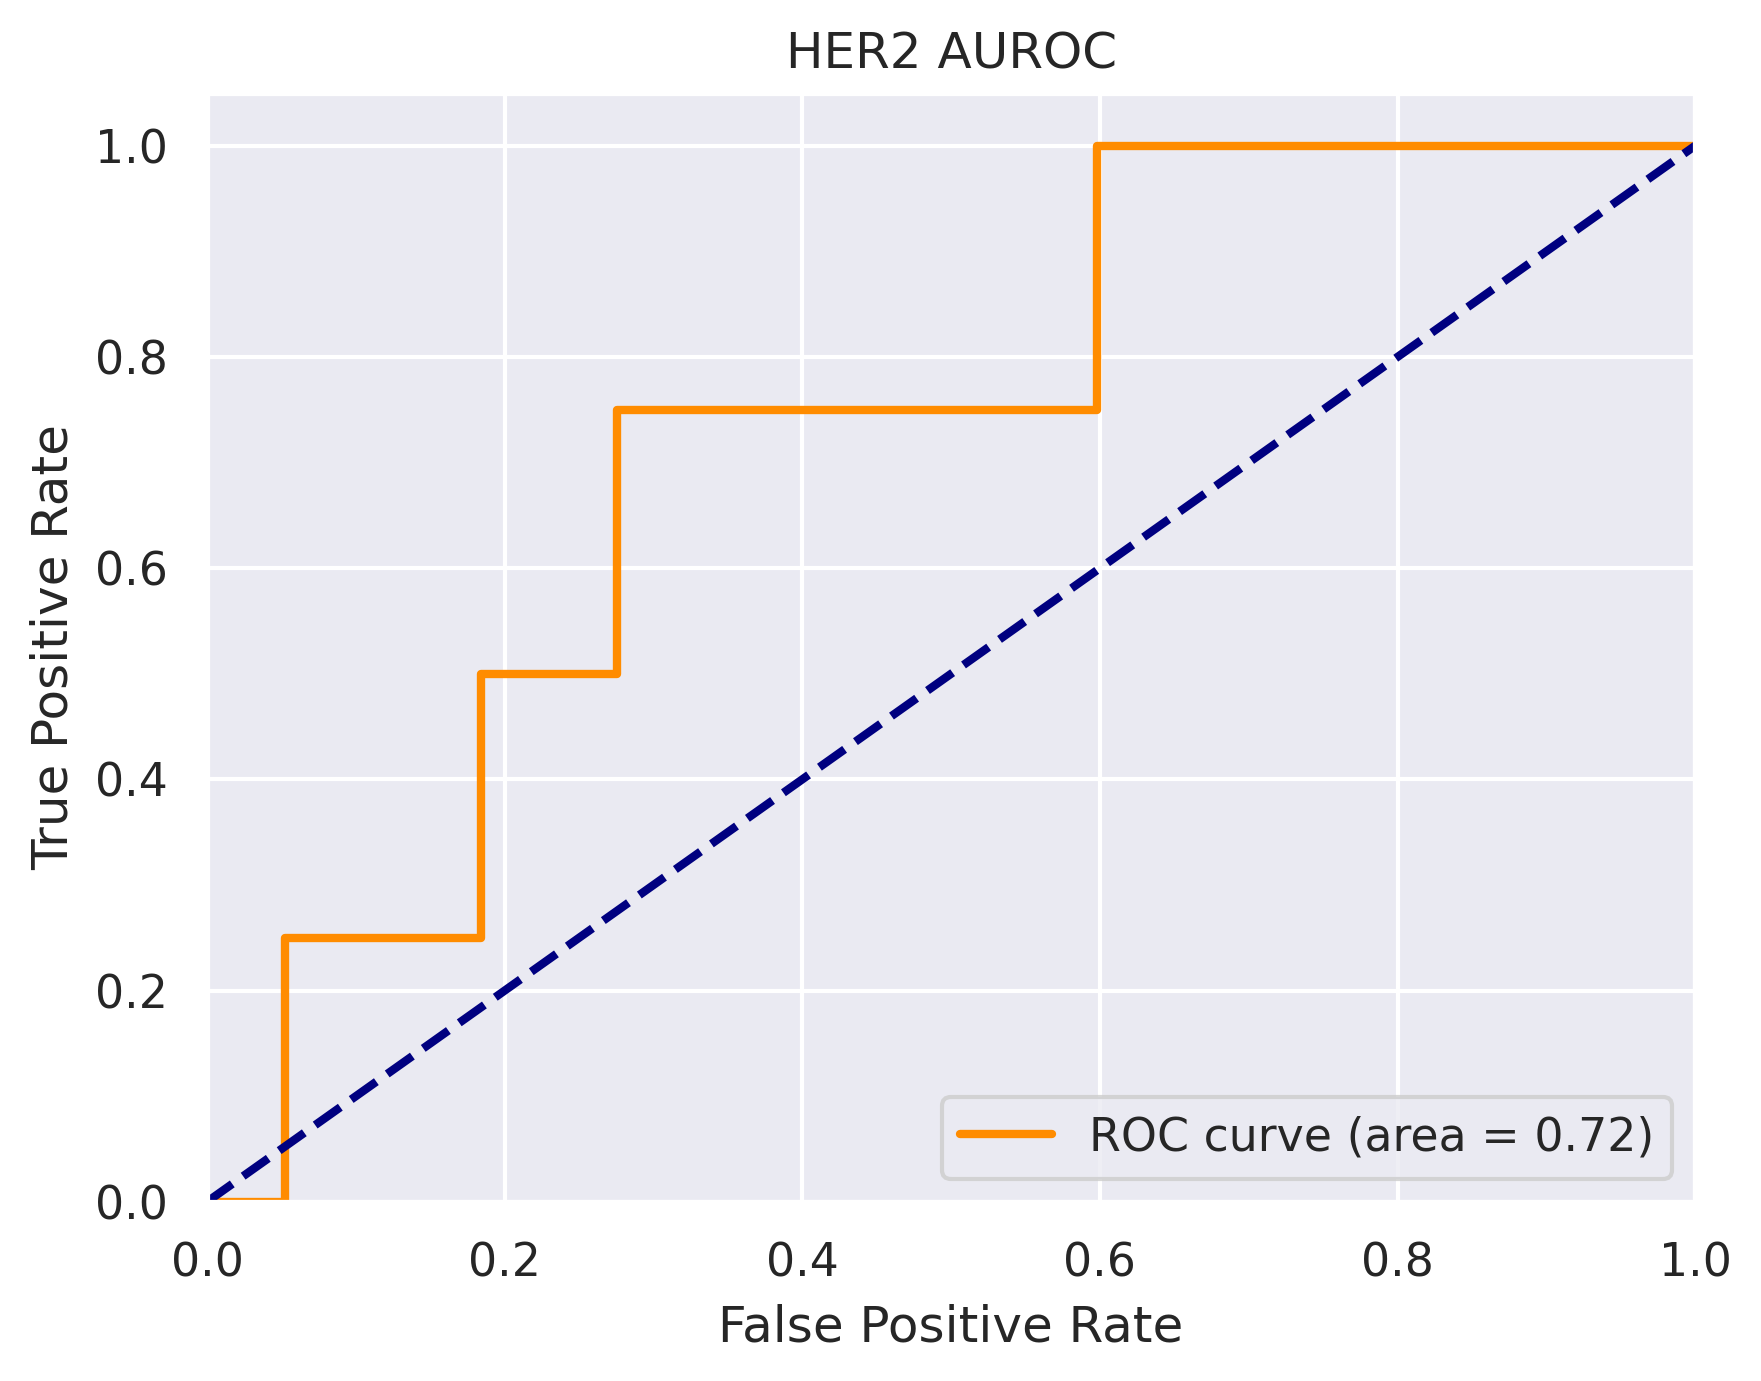

In [18]:
pred, label = [], []
for ab in tqdm(test_HER2):
    binder, target = AntibodyDataset.make_local_batch([ab], embedding, model_args)
    score = model.predict(binder, target)
    pred.append(score.item())
    label.append(int(ab['affinity'] < -8.7))  # better than wildtype trastuzumab binding affinity 

fpr, tpr, _ = roc_curve(label, pred)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc_score(label, pred),
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("HER2 AUROC")
plt.legend(loc="lower right")
plt.show()

#### SKEMPI Results

In [19]:
test_data = ProteinDataset("data/skempi/skempi_all.pkl", 50)
embedding = load_esm_embedding(test_data.data, ['binder_full', 'target_full'])

100%|██████████| 6075/6075 [00:08<00:00, 750.85it/s] 


In [20]:
model_ckpt, _, model_args = torch.load("ckpts/model.skempi.allatom")
model = AllAtomEnergyModel(model_args).cuda()
model.load_state_dict(model_ckpt)
model.eval()

AllAtomEnergyModel(
  (mse_loss): MSELoss()
  (encoder): AllAtomEncoder(
    (W_bind): Linear(in_features=2560, out_features=256, bias=True)
    (W_tgt): Linear(in_features=2560, out_features=256, bias=True)
    (A_bind): Embedding(63, 256)
    (A_tgt): Embedding(63, 256)
    (encoder): SRUpp(
      (rnn_lst): ModuleList(
        (0): SRUppCell(515, 128, bidirectional=True, highway_bias=-2.0,
          transform_module=SRUppAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (linear1): Linear(in_features=515, out_features=128, bias=False)
          (linear2): Linear(in_features=128, out_features=256, bias=False)
          (linear3): Linear(in_features=128, out_features=1024, bias=False)
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        )
      )
    )
  )
  (W_o): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (

In [21]:
with torch.no_grad():
    wt_map = {}
    pred, label = [], []
    for entry in test_data.data:
        pdb, mutation, ddg = entry['pdb']
        if len(mutation) == 0:
            binder, target = ProteinDataset.make_local_batch([entry], embedding, model_args, 'binder', 'target')
            wt_map[pdb] = model.predict(binder, target) + model.predict(target, binder)

    for entry in test_data.data:
        pdb, mutation, ddg = entry['pdb']
        if len(mutation) > 0:
            binder, target = ProteinDataset.make_local_batch([entry], embedding, model_args, 'binder', 'target')
            score = model.predict(binder, target) + model.predict(target, binder)
            score = score - wt_map[pdb]
            pred.append(-1.0 * score.item())
            label.append(ddg)

Text(0.5, 1.0, 'SKEMPI test correlation: Spearman R = 0.4218')

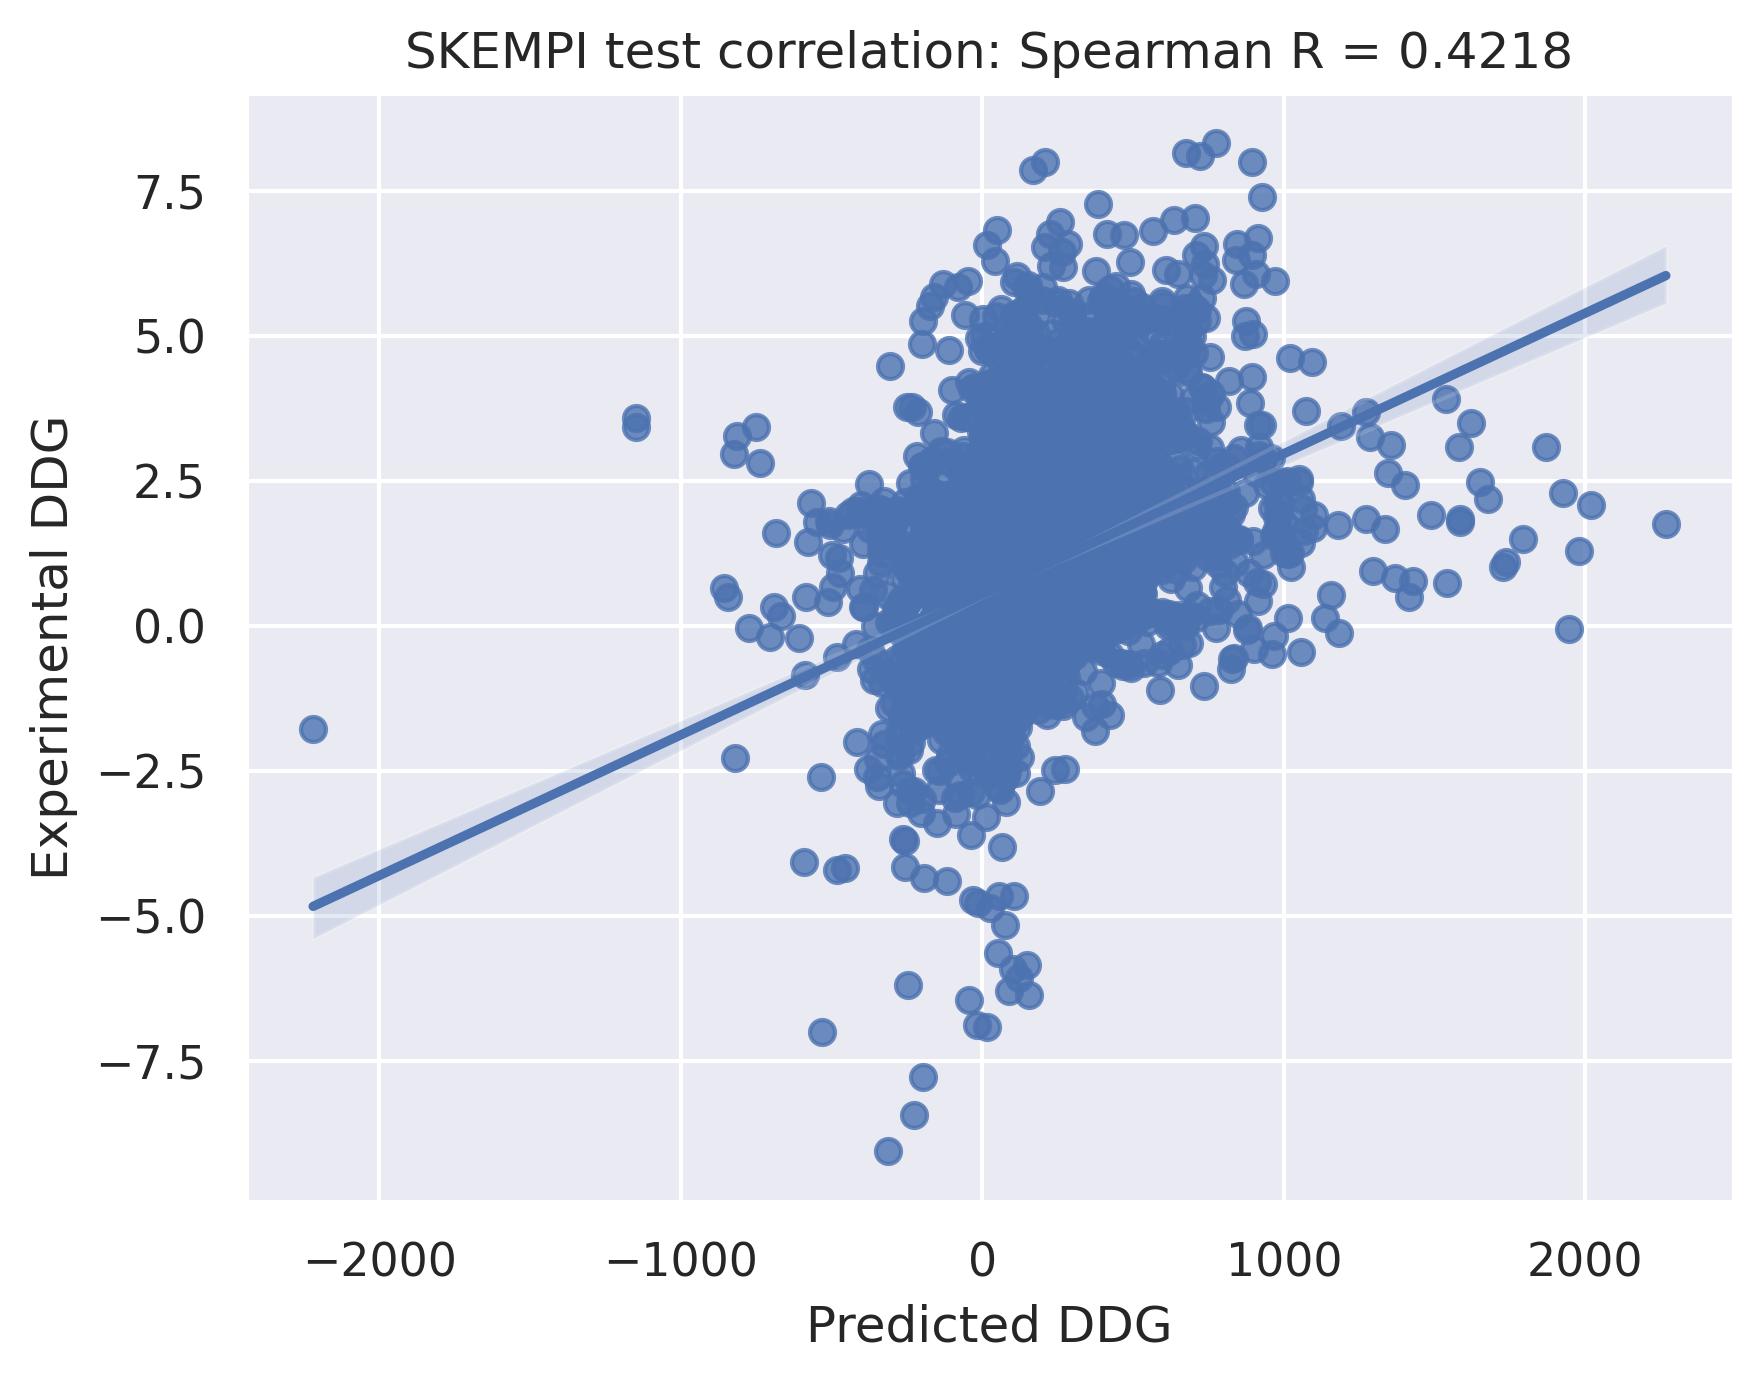

In [22]:
test_corr = scipy.stats.spearmanr(pred, label)[0]
sns.regplot(x=pred, y=label)
plt.xlabel('Predicted DDG')
plt.ylabel('Experimental DDG')
plt.title(f'SKEMPI test correlation: Spearman R = {test_corr:.4f}')

### Ligand virtual screening

In [4]:
torch.cuda.set_device(0)
fn = 'ckpts/model.recA'
model_ckpt, opt_ckpt, model_args = torch.load(fn)
model = DrugAllAtomEnergyModel(model_args).cuda()
model.load_state_dict(model_ckpt)
model.eval()

DrugAllAtomEnergyModel(
  (mse_loss): MSELoss()
  (mpn): MPNEncoder(
    (dropout_layer): Dropout(p=0.1, inplace=False)
    (act_func): ReLU()
    (W_i): Linear(in_features=147, out_features=256, bias=False)
    (W_h): Linear(in_features=256, out_features=256, bias=False)
    (W_o): Linear(in_features=389, out_features=256, bias=True)
  )
  (encoder): AllAtomEncoder(
    (W_bind): Linear(in_features=256, out_features=256, bias=True)
    (W_tgt): Linear(in_features=2560, out_features=256, bias=True)
    (A_bind): Embedding(38, 256)
    (A_tgt): Embedding(38, 256)
    (encoder): SRUpp(
      (rnn_lst): ModuleList(
        (0): SRUppCell(515, 128, dropout=0.1, bidirectional=True, highway_bias=-2.0,
          transform_module=SRUppAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (linear1): Linear(in_features=515, out_features=128, bias=False)
          (linear2): Linear(in_features=128, out_features=256, bias=False)
          (linear3): Linear(in_features=128, out_fe

In [6]:
sdf_list = sorted(glob.glob('data/recA/*/rank1.sdf'))
result, _ = model.virtual_screen('data/recA/1xmv.pdb', sdf_list, batch_size=1)
pd.DataFrame(result)

100%|██████████| 198/198 [00:00<00:00, 934.21it/s]


,0,1,2
0,data/recA/recA_1/rank1.sdf,CC(C)=CCC/C(C)=C\COc1ccc2ccc(=O)oc2c1,-87.425337
1,data/recA/recA_10/rank1.sdf,COc1cc(C)c(C(=O)Oc2cc(C)c(C(=O)O)c(O)c2)c(O)c1,-87.975159
2,data/recA/recA_100/rank1.sdf,CC(=O)c1c(O)cc(O)cc1O,-134.398275
3,data/recA/recA_101/rank1.sdf,COc1ccc(-c2cc(=O)c3c(O)c(OC)c(OC)c(OC)c3o2)cc1OC,-69.654306
4,data/recA/recA_102/rank1.sdf,O=C(O)c1ccc2c(c1)OCO2,-147.549316
...,...,...,...
193,data/recA/recA_95/rank1.sdf,CC(=O)O[C@@H]1C[C@H]2C(C)(C)C(=O)C=C[C@]2(C)[C...,-112.395091
194,data/recA/recA_96/rank1.sdf,COc1cc(O)cc(O)c1C(=O)c1ccccc1,-119.952935
195,data/recA/recA_97/rank1.sdf,CN1CCc2cc3c(cc2[C@H]1[C@@H]1OC(=O)c2c1ccc1c2OC...,-65.517302
196,data/recA/recA_98/rank1.sdf,CC(=O)O[C@H]1CC[C@@]2(C)[C@@H](C[C@@H](OC(C)=O...,-107.788773
